In [1]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm


In [2]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [3]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

## Q1
각 도착지에 따른 비행거리와 도착지연시간과의 관계를 알아보고자 함.

1. Group flights by destination.
2. Summarise to compute distance, average delay, and number of flights.
3. Filter to remove noisy points and Honolulu airport, which is almost twice as far away as the next closest airport.


In [14]:
# Load the nycflight13 dataset
flights = sm.datasets.get_rdataset("flights", "nycflights13").data.drop(columns="time_hour")

In [37]:
# grouping by destinations
by_dest = flights.groupby("dest")

In [43]:
delay = by_dest[["distance", "arr_delay"]].agg(["size", "mean"])
delay.head()

     distance         arr_delay      
         size    mean      size  mean
dest                                 
ABQ       254 1826.00       254  4.38
ACK       265  199.00       265  4.85
ALB       439  143.00       439 14.40
ANC         8 3370.00         8 -2.50
ATL     17215  757.11     17215 11.30

In [44]:
delay.columns = ['_'.join(col_agg) for col_agg in delay.columns] # columns 이름을 새로 부여
delay.drop(columns="arr_delay_size", inplace=True) # arr_delay_count 열 삭제
delay.columns = ["count", "dist", "delays"] # rename the columns
delay.reset_index(inplace=True) # reset index (dest)

In [45]:
delay.head()

  dest  count    dist  delays
0  ABQ    254 1826.00    4.38
1  ACK    265  199.00    4.85
2  ALB    439  143.00   14.40
3  ANC      8 3370.00   -2.50
4  ATL  17215  757.11   11.30

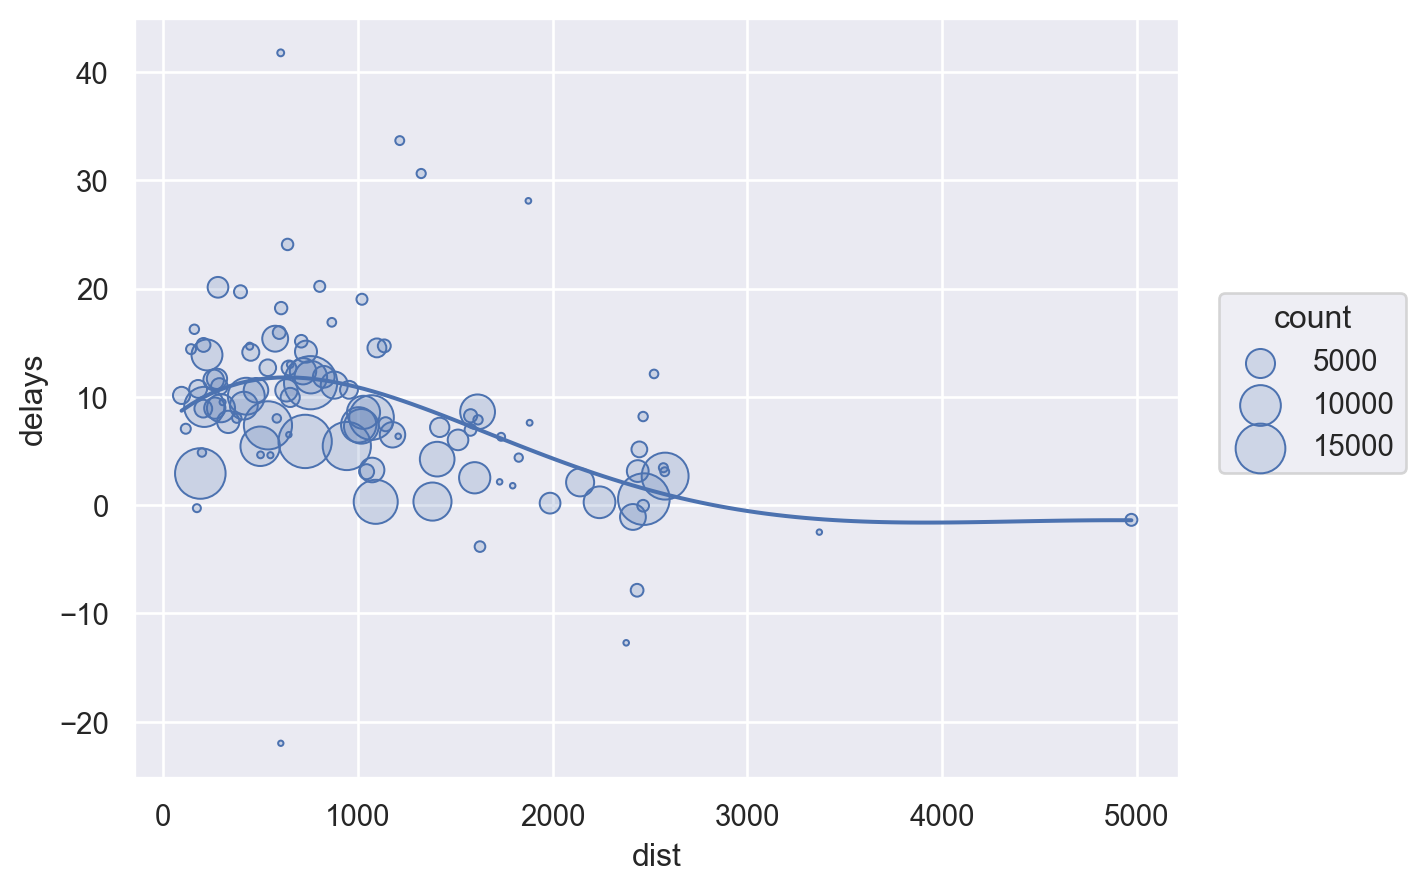

In [46]:
(
    so.Plot(delay, x="dist", y="delays")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(2, 20))
)

불필요한 자료를 제거하고 시각화하는 것이 유리

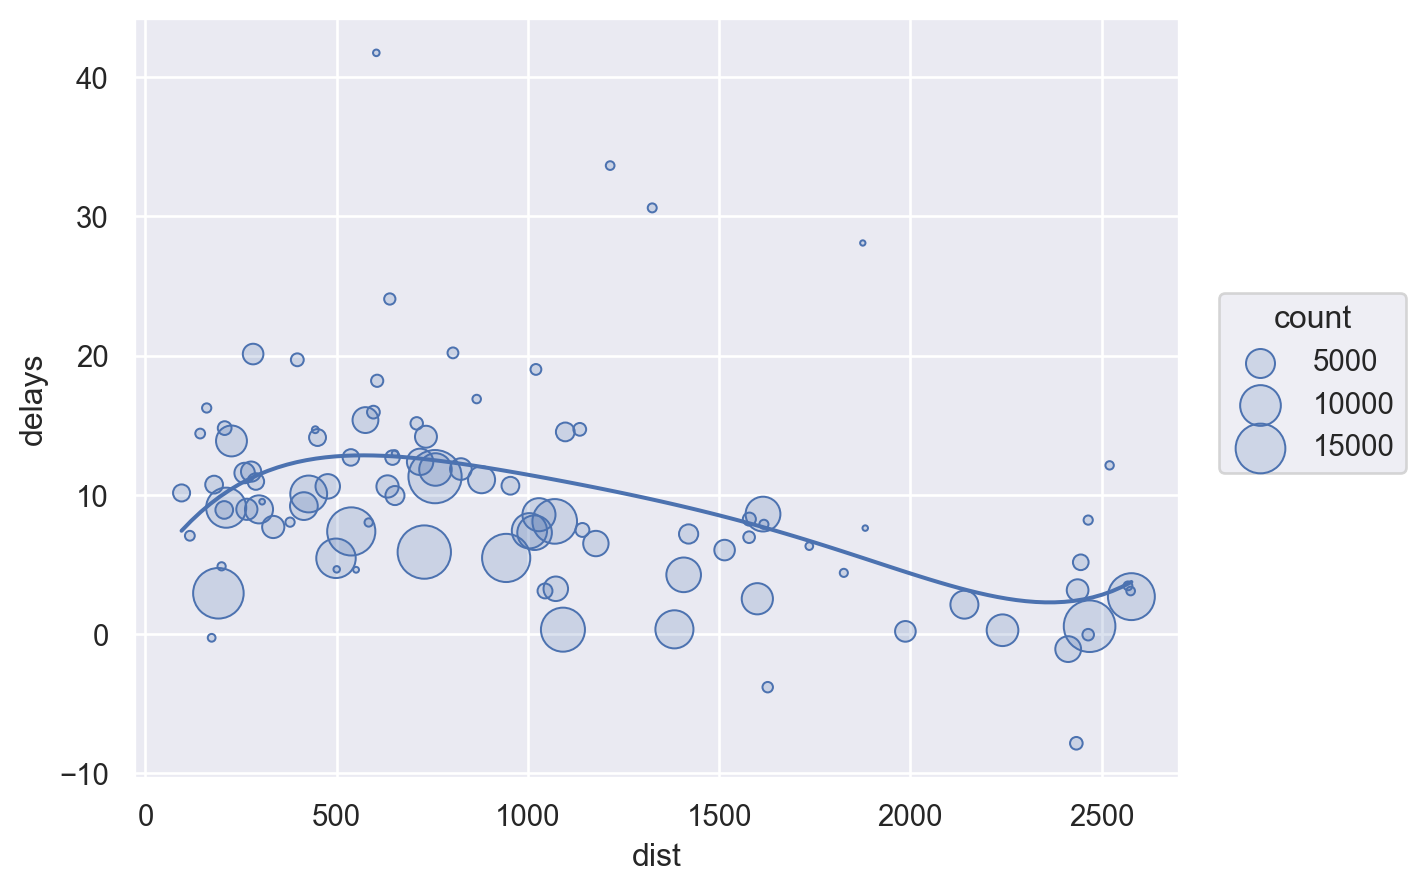

In [42]:
# Filter to remove noisy points and Honolulu airport
delay_sub = delay.query('count > 20 & dest != "HNL"')
(
    so.Plot(delay_sub, x="dist", y="delays")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(2, 20))
)

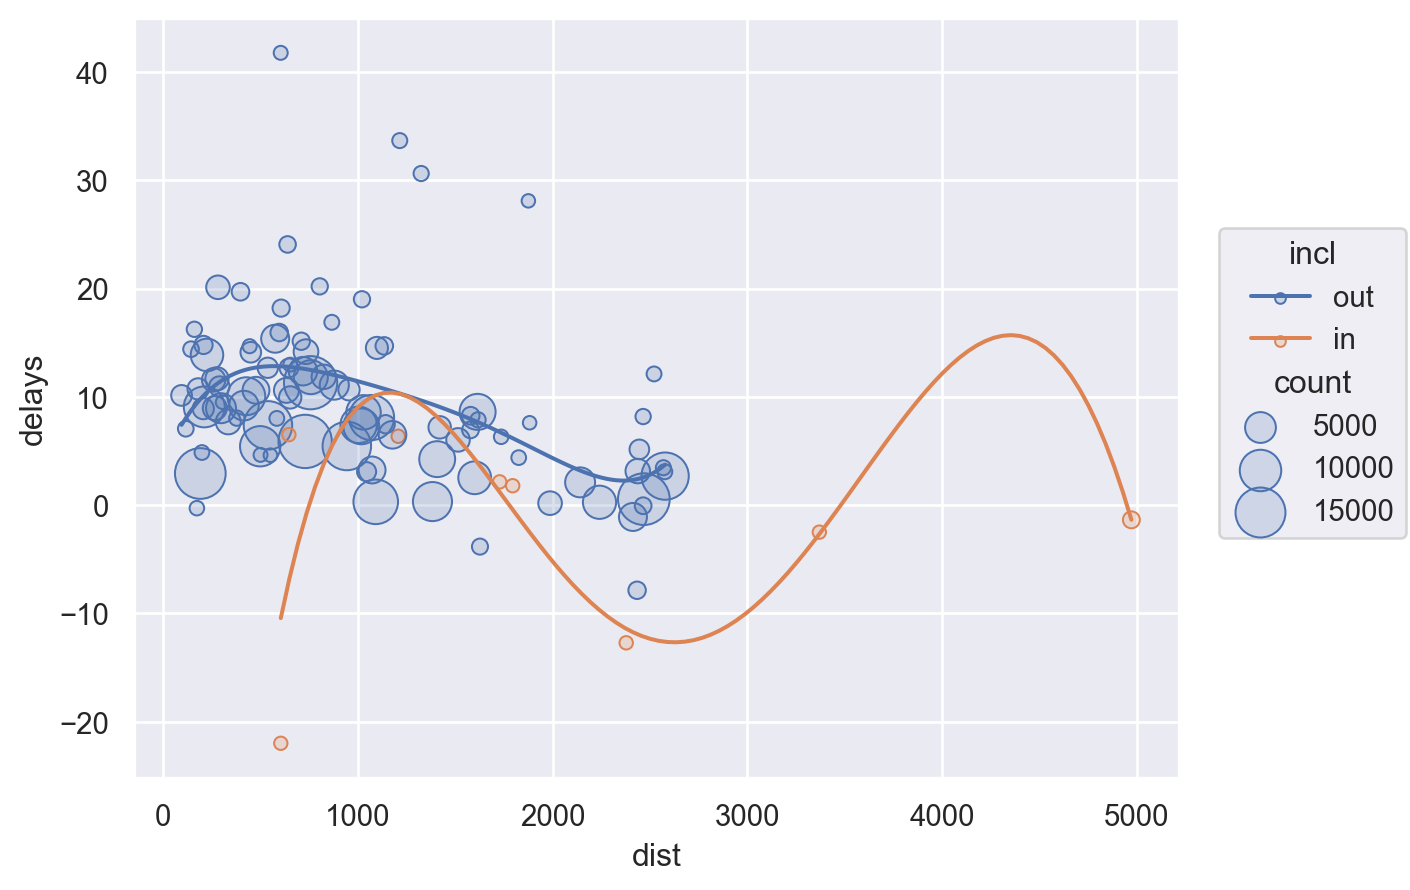

In [43]:
#| echo: false
#| output: false
idx = (delay["count"] > 20) & (delay["dest"] != "HNL")
delay["incl"] = np.where(idx, "out", "in") 

(
    so.Plot(delay, x="dist", y="delays", color="incl")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(5, 20))
).save("images/plot3.png")

::: {.callout-tip}
다음과 같이 제외되는 자료에 대해 label 혹은 True/False을 붙여 관리하는 것도 방법
```python
idx = (delay["count"] > 20) & (delay["dest"] != "HNL")
delay["incl"] = np.where(idx, "out", "in")  # idx가 True인 곳은 "out", False인 곳은 "in"
delay
#   dest  count    dist  delay incl
# 0  ABQ    254 1826.00   4.38  out
# 1  ACK    265  199.00   4.85  out
# 2  ALB    439  143.00  14.40  out
# 3  ANC      8 3370.00  -2.50   in
# 4  ATL  17215  757.11  11.30  out
...

# 제외되는 데이터를 같이 볼 수 있음
(
    so.Plot(delay, x="dist", y="delay", color="incl")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(5, 20))
)
```
![](images/plot3.png){width=400}
:::

## Q2
평균적으로 가장 연착시간이 큰 항공기(tail number로 구분)를 살펴보는데,    
우선, `count()`를 사용하여 샘플 수가 극히 작은 케이스들 혹은 극단치들을 제거해서 살펴보는 것이 유리함.

In [57]:
delays = flights.groupby("tailnum")[["arr_delay"]].mean() # as DataFrame
delays

         arr_delay
tailnum           
D942DN       31.50
N0EGMQ        9.98
N10156       12.72
...            ...
N998DL       16.39
N999DN       14.31
N9EAMQ        9.24

[4043 rows x 1 columns]

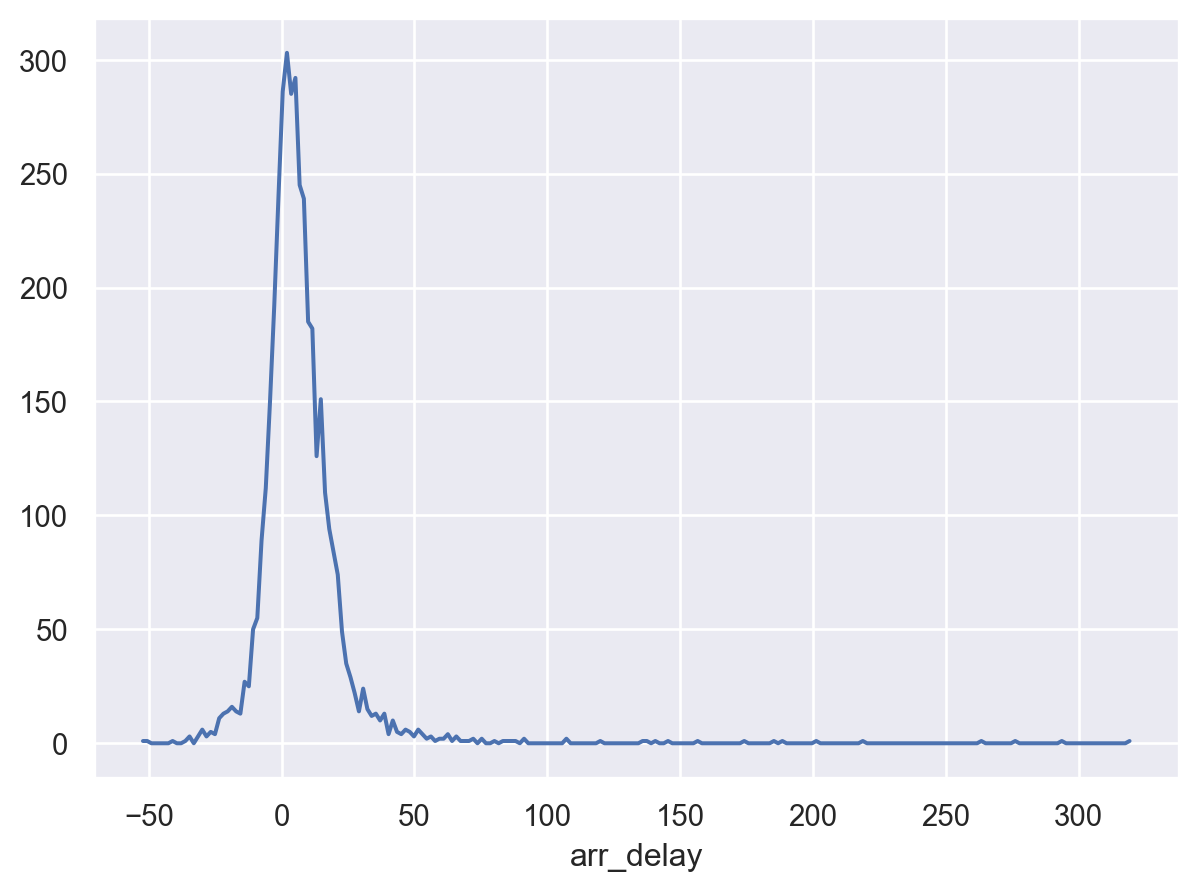

In [58]:
(
    so.Plot(delays, x="arr_delay")
    .add(so.Line(), so.Hist())
)

::: {.callout-tip}
pandas DataFrame method
```python
delays.hist(bins=100)
```
:::

300분이 넘는 delay도 있음을 보는데, 각 평균 delay값이 몇 개 항목의 평균인지 살펴보면 흥미로운 사실을 발견할 수 있음. 즉,

In [64]:
delays = (
    flights
    .groupby("tailnum")["arr_delay"]
    .agg([("delay", "mean"), ("n", "count")])
)
delays

         delay    n
tailnum            
D942DN   31.50    4
N0EGMQ    9.98  352
N10156   12.72  145
...        ...  ...
N998DL   16.39   76
N999DN   14.31   61
N9EAMQ    9.24  238

[4043 rows x 2 columns]

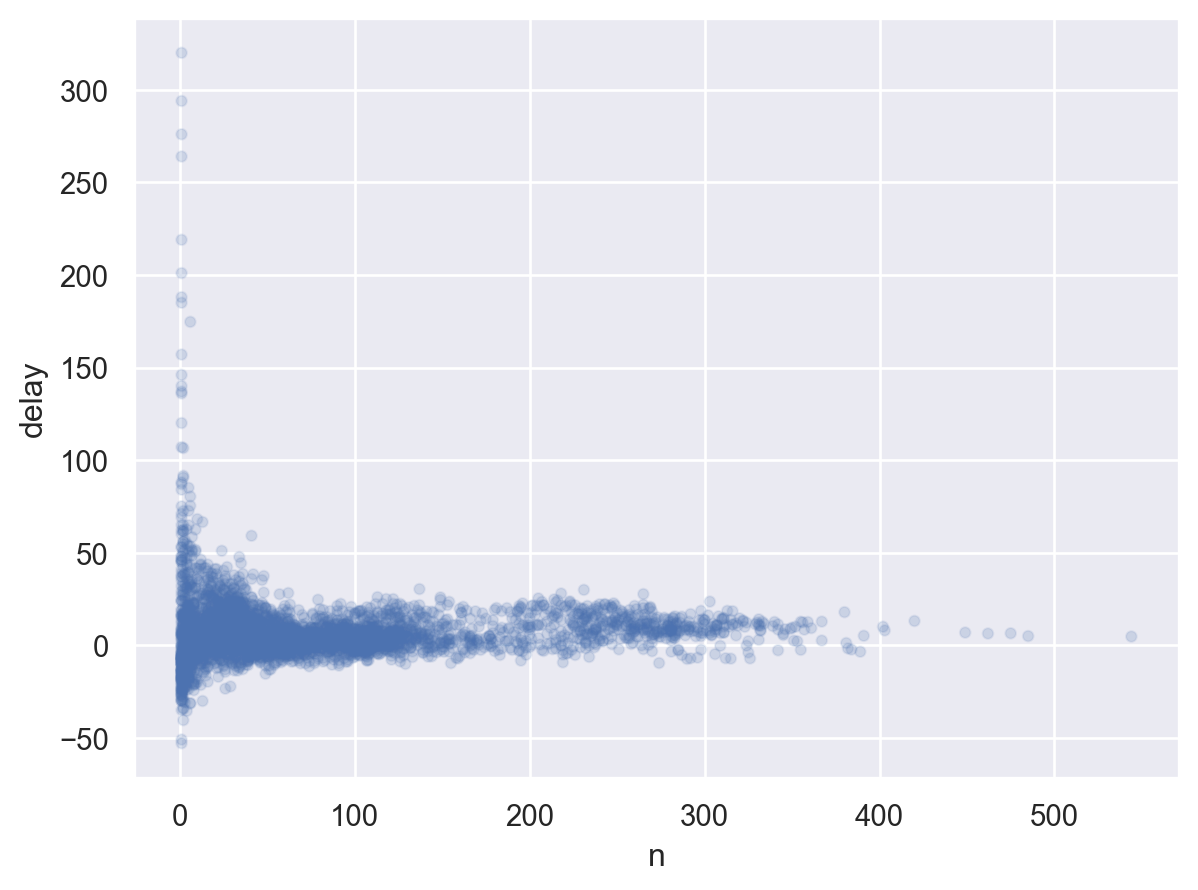

In [68]:
(
    so.Plot(delays, x="n", y="delay")
    .add(so.Dots(alpha=.1))
)

비행횟수가 작을수록 편차가 크게 나타나는데,  
일반적으로 샘플수가 클수록 평균들의 편차가 줄어드는 현상이 나타남.

위와 같은 플랏을 볼 때, 샘플 수가 매우 작은 그룹들은 제외하고 살펴보는 것이 패턴을 파악하는데 종종 도움이 됨.  
간단하게, `query()` method를 이용하면 편리

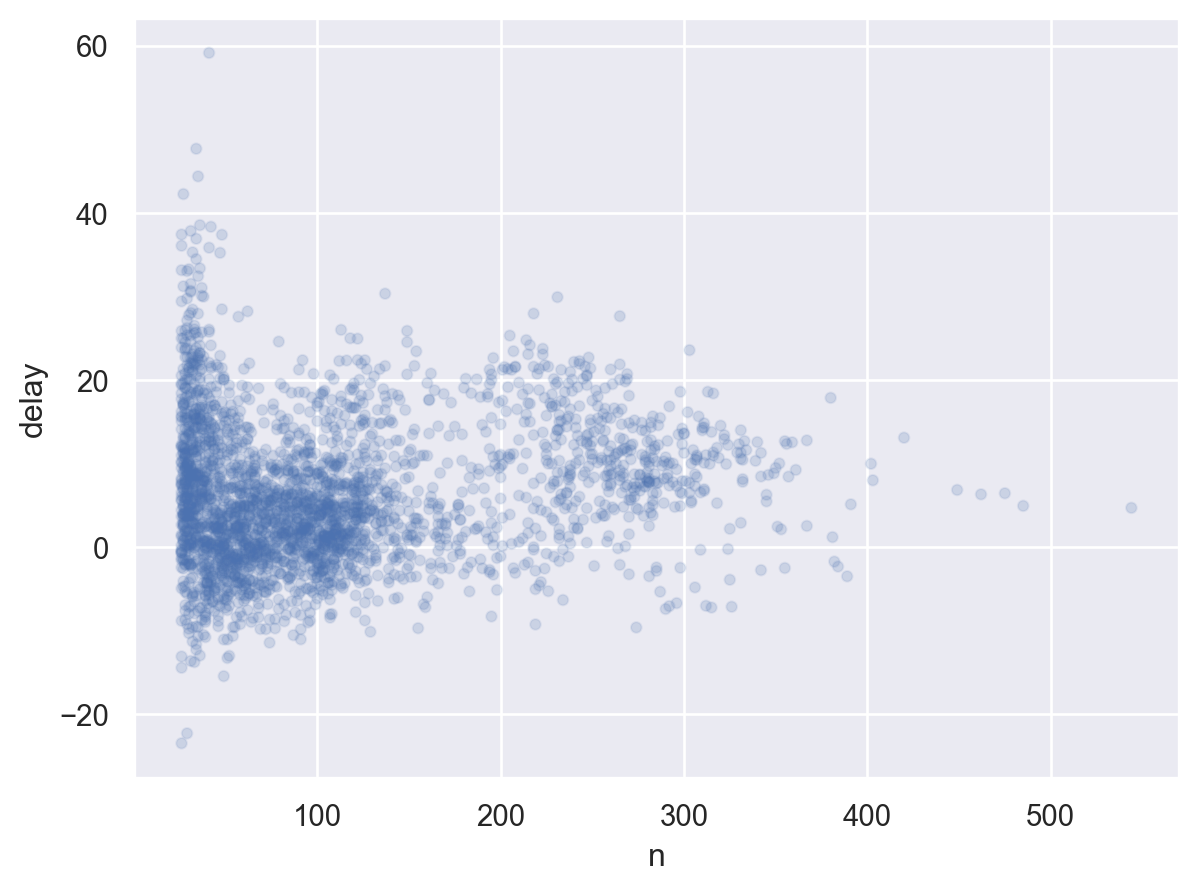

In [69]:
(
    so.Plot(delays.query('n > 25'), x="n", y="delay")
    .add(so.Dots(alpha=.1))
)

## Q3

In [71]:
# Lahman's Baseball Database
batting = pd.read_csv("https://raw.githubusercontent.com/beanumber/baseball_R/master/data/Batting.csv") 

In [72]:
batting

        playerID  yearID  stint teamID lgID    G  G_batting     AB     R  \
0      aardsda01    2004      1    SFN   NL   11         11   0.00  0.00   
1      aardsda01    2006      1    CHN   NL   45         43   2.00  0.00   
2      aardsda01    2007      1    CHA   AL   25          2   0.00  0.00   
...          ...     ...    ...    ...  ...  ...        ...    ...   ...   
95192  zwilldu01    1914      1    CHF   FL  154        154 592.00 91.00   
95193  zwilldu01    1915      1    CHF   FL  150        150 548.00 65.00   
95194  zwilldu01    1916      1    CHN   NL   35         35  53.00  4.00   

           H  ...    SB   CS    BB    SO  IBB  HBP    SH   SF  GIDP  G_old  
0       0.00  ...  0.00 0.00  0.00  0.00 0.00 0.00  0.00 0.00  0.00  11.00  
1       0.00  ...  0.00 0.00  0.00  0.00 0.00 0.00  1.00 0.00  0.00  45.00  
2       0.00  ...  0.00 0.00  0.00  0.00 0.00 0.00  0.00 0.00  0.00   2.00  
...      ...  ...   ...  ...   ...   ...  ...  ...   ...  ...   ...    ...  
95192 

In [77]:
# AB: At Bats 타석에 나선 횟수, H: Hits; times reached base 출루한 횟수
batters = batting.groupby("playerID")[["H", "AB"]].sum()
batters = batters.assign(
    BA = lambda x: x.H / x.AB   # BA: batting average 타율
)
batters

                H       AB   BA
playerID                       
aardsda01    0.00     3.00 0.00
aaronha01 3771.00 12364.00 0.30
aaronto01  216.00   944.00 0.23
...           ...      ...  ...
zuvelpa01  109.00   491.00 0.22
zuverge01   21.00   142.00 0.15
zwilldu01  364.00  1280.00 0.28

[17661 rows x 3 columns]

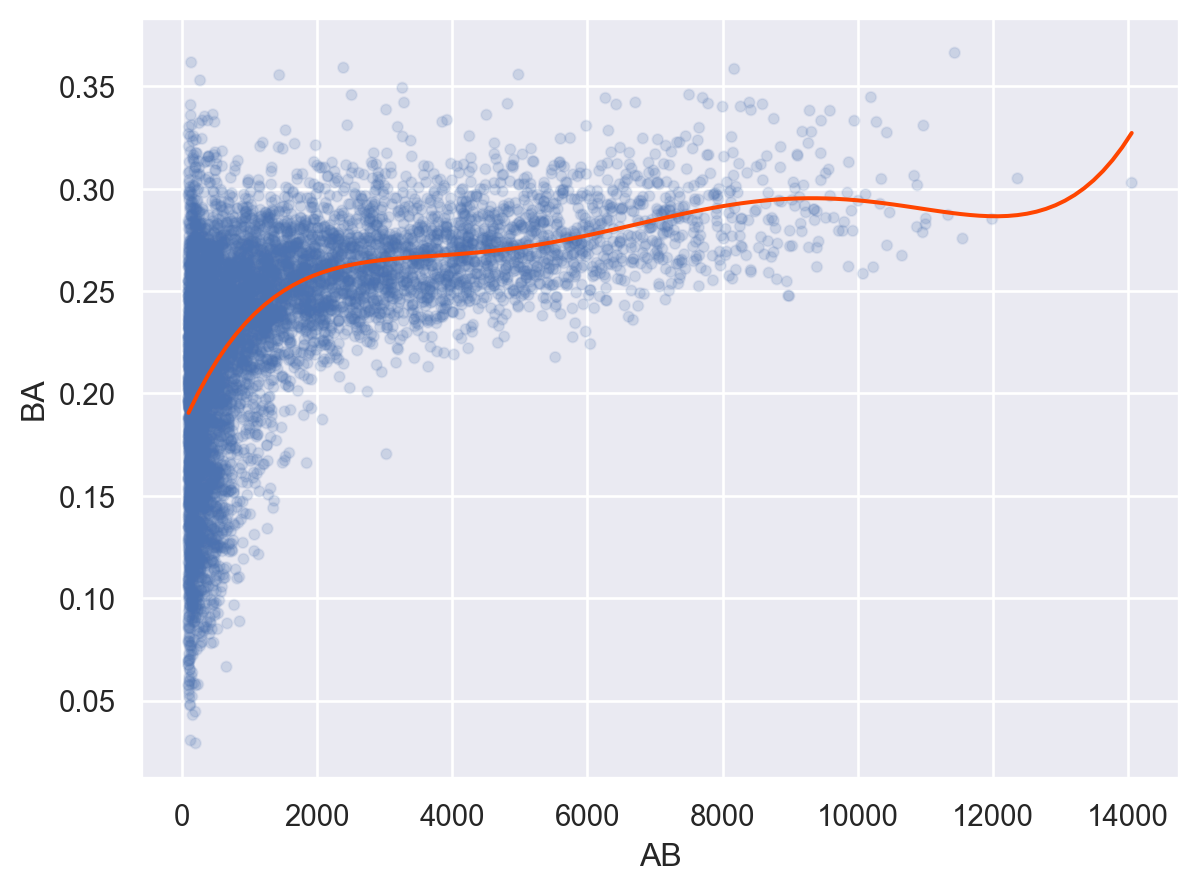

In [84]:
# filtering없이 보았을 때와 비교해서 어느 정도 제외할지 고민
(
    so.Plot(batters.query('AB > 100'), x="AB", y="BA")
    .add(so.Dots(alpha=.1))
    .add(so.Line(color="orangered"), so.PolyFit(5))
)

In [88]:
# 1번 기회를 얻은 타자... 타율 100%
batters.sort_values("BA", ascending=False).head(10)

             H   AB   BA
playerID                
paciojo01 3.00 3.00 1.00
gallaja01 1.00 1.00 1.00
sellsda01 1.00 1.00 1.00
...        ...  ...  ...
kehnch01  2.00 2.00 1.00
devinha01 2.00 2.00 1.00
liddeda01 1.00 1.00 1.00

[10 rows x 3 columns]